# Time Slots by Attack Type

Extract the timestamp of each attack from a block:

- displacement: the block containing the attacker transaction
- insertion: the block containing the first attacker, the victim and the second attacker transactions
- suppression: the block containing the first attacker transaction

Plot by attack type in different time slots (year, month, weekday, hour).

We do not think that the hour is a good indicator since Ethereum is a distributed system with users from all over the world.

In [1]:
import calendar
import json
import os
import pickle
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pandas.plotting import register_matplotlib_converters


register_matplotlib_converters()

%matplotlib inline

plt.style.use("seaborn")

In [2]:
data_directory = os.path.join("..", "..", "data")

In [3]:
attack_type_colors = sns.color_palette("pastel", 3)

attack_type_palette = {
    "displacement": attack_type_colors[0],
    "insertion": attack_type_colors[1],
    "suppression": attack_type_colors[2],
}

In [4]:
def load_results(attack_type):
    results_file_name = "{}_results.json".format(attack_type)
    results_file_path = os.path.join(data_directory, results_file_name)

    if not os.path.exists(results_file_path):
        compressed_file_path = os.path.join(data_directory, "{}_results.tar.xz".format(attack_type))
        with tarfile.open(compressed_file_path, "r:xz", encoding="utf-8") as compressed_file:
            compressed_file.extract(results_file_name, data_directory)
            
    with open(results_file_path, "r", encoding="utf-8") as results_file:
        results = []
        line = results_file.readline().strip()
        while line != "":
            results.append(json.loads(line))
            line = results_file.readline().strip()
    return results

I had to do an extra step for displacement attacks because we did not have their timestamps:

In [5]:
with open(os.path.join(data_directory, "displacement_block_timestamps.pickle"), "rb") as pikle_file:
    timestamp_by_block = pickle.load(pikle_file)

In [6]:
timestamp_extractor_by_attack = {
    "displacement": lambda result: timestamp_by_block[result["attacker_transaction"]["blockNumber"]],
    "insertion": lambda result: result["block_timestamp"],
    "suppression": lambda result: result["block_timestamp"],
}

In [7]:
rows = []

for attack_type, timestamp_extractor in timestamp_extractor_by_attack.items():
    print("Loading {} results...".format(attack_type))
    results = load_results(attack_type)
    
    for result in results:
        attack_timestamp = timestamp_extractor(result)
        attack_date = datetime.fromtimestamp(attack_timestamp)
        
        rows.append({
            "Type": attack_type,
            "Year": attack_date.year,
            "Month": attack_date.month,
            "Weekday": attack_date.weekday(),
            "Hour": attack_date.hour
        })
            
    print("Deleting {} results...".format(attack_type))
    del results

print("Building dataframe...")
df = pd.DataFrame(rows)

Loading displacement results...
Deleting displacement results...
Loading insertion results...
Deleting insertion results...
Loading suppression results...
Deleting suppression results...
Building dataframe...


There is only one case before 2018, we can remove it for better plots:

In [8]:
len(df[df.Year < 2018])

1

In [9]:
df = df[df.Year >= 2018]

## Percentage per time slot

Shows how the proportion of attacks per year/month/weekday/hour and per attack type.

In [10]:
def plot_by_time_slot(name, label_formatter=None, rotate_x_label=False, figsize=(5, 3)):
    percentage = df.groupby(["Type"])[name].\
        value_counts(normalize=True).\
        mul(100).\
        rename("Percentage").\
        reset_index().\
        sort_values(["Type", name])

    if label_formatter is not None:
        percentage[name] = percentage[name].map(label_formatter)

    plt.figure(figsize=figsize)
    
    g = sns.barplot(
        x=name,
        y="Percentage",
        hue="Type",
        data=percentage,
        palette=attack_type_palette)
    
    g.legend_.set_title(None)
    g.legend_.texts[0].set_text("Displacement")
    g.legend_.texts[1].set_text("Insertion")
    g.legend_.texts[2].set_text("Suppression")
    
    if rotate_x_label:
        plt.xticks(rotation='vertical')
        
    plt.tight_layout()
    plt.savefig(os.path.join(data_directory, "{}_percentage.pdf".format(name.lower())), dpi=1000)
    plt.show()

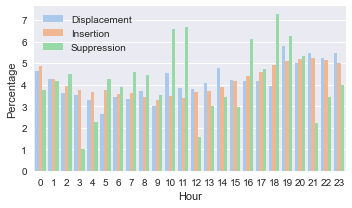

In [11]:
plot_by_time_slot("Hour")

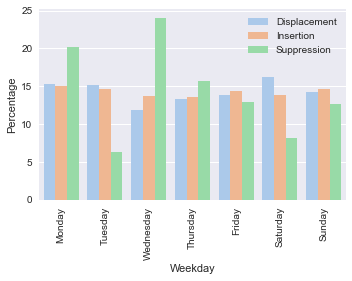

In [12]:
plot_by_time_slot("Weekday", lambda weekday: calendar.day_name[weekday], rotate_x_label=True, figsize=(5, 4))

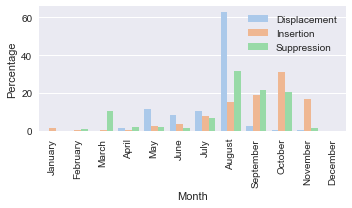

In [13]:
plot_by_time_slot("Month", lambda month: calendar.month_name[month], rotate_x_label=True)

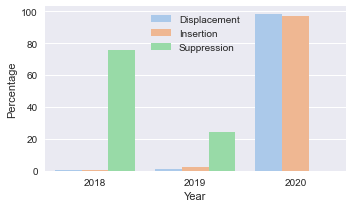

In [14]:
plot_by_time_slot("Year")

## Trends

Shows the number of attacks per attack type and Year-Month sorted chronologically.

The insertion cases completely occlude the other two cases.

In [15]:
df_month_count = df.groupby(["Type", "Year", "Month"])["Month"].count()\
    .rename("Count")\
    .reset_index()

In [16]:
df_month_count["Date"] = df_month_count.apply(lambda row: "{:d}-{:02d}".format(row["Year"], row["Month"]), axis=1)
df_month_count = df_month_count.sort_values(by="Date")

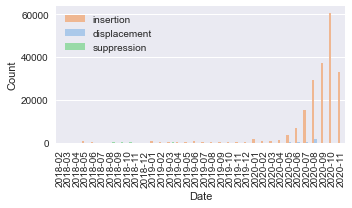

In [17]:
plt.figure(figsize=(5, 3))
sns.barplot(
    data=df_month_count,
    x="Date",
    y="Count",
    palette=attack_type_palette,
    hue="Type")
plt.xticks(rotation='vertical')
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(data_directory, "count_by_date.pdf".format(attack_type)), dpi=1000)
plt.show()

The log scale on the count can make the other two cases more visible but the y axis is less easy to interpret.

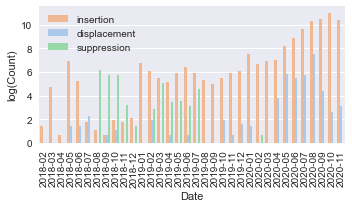

In [18]:
plt.figure(figsize=(5, 3))
sns.barplot(
    x=df_month_count["Date"],
    y=np.log(df_month_count["Count"]),
    palette=attack_type_palette,
    hue=df_month_count["Type"])
plt.xticks(rotation='vertical')
plt.ylabel("log(Count)")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(data_directory, "log_count_by_date.pdf".format(attack_type)), dpi=1000)
plt.show()

## Weekday-Hour Heatmaps

Not very clear information in any case.

In [19]:
def weekday_hour_heatmap(attack_type):
    df_attack_type = df[df.Type == attack_type]
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(pd.crosstab(df_attack_type.Weekday, df_attack_type.Hour))
    
    plt.yticks(np.arange(len(calendar.day_name)) + 0.5,
               list(calendar.day_name),
               rotation='horizontal')
    
    plt.tight_layout()
    plt.ylabel("")
    plt.savefig(os.path.join(data_directory, "{}_weekday_hour.pdf".format(attack_type)), dpi=1000)
    plt.show()

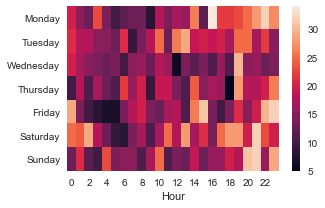

In [20]:
weekday_hour_heatmap("displacement")

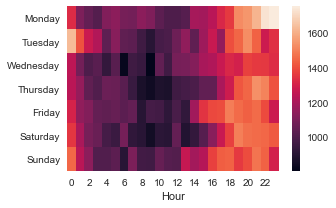

In [21]:
weekday_hour_heatmap("insertion")

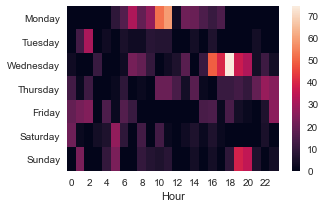

In [22]:
weekday_hour_heatmap("suppression")